In [38]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model
from keras.layers import Dropout
def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))

In [28]:
exchange_data = pd.read_csv('EURO_INR_new.csv')
exchange_data["Date"] = pd.to_datetime(exchange_data["Date"])
ind_exchange_data = exchange_data.set_index(["Date"], drop=True)

In [29]:
ind_exchange_data.head()

,Price,Open,High,Low,Change %
Date,,,,,
2018-10-29,83.4930,83.7660,83.8630,83.2730,-0.33%
2018-10-28,83.7660,83.7660,83.7660,83.7660,-0.03%
2018-10-26,83.7885,83.2935,83.8995,83.1565,0.58%
2018-10-25,83.3025,83.4205,83.7905,83.1375,-0.15%
2018-10-24,83.4235,84.3615,84.4055,83.2315,-1.13%


In [30]:
data_frame = ind_exchange_data.sort_index(axis=1 ,ascending=True)
data_frame = data_frame.iloc[::-1]
data_frame.head()

,Change %,High,Low,Open,Price
Date,,,,,
1980-01-02,0.45%,12.119,12.119,12.119,12.119
1980-01-03,-0.44%,12.066,12.066,12.066,12.066
1980-01-04,0.94%,12.179,12.179,12.179,12.179
1980-01-07,0.25%,12.210,12.210,12.210,12.210
1980-01-08,-0.39%,12.162,12.162,12.162,12.162


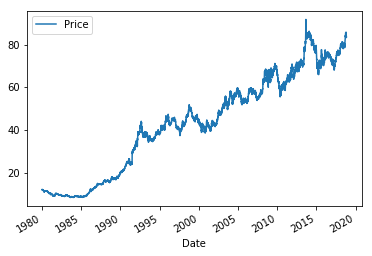

In [31]:
df = data_frame[["Price"]]
df.plot()

In [32]:
diff = df.index.values[-1] - df.index.values[0]
days = diff.astype('timedelta64[D]')
days = days / np.timedelta64(1, 'D')
years = int(days/365)
print("Total data: %d years"%years)
print("80 percent data = 1980 to %d"%(1980 + int(0.8*years)))

Total data: 38 years
80 percent data = 1980 to 2010


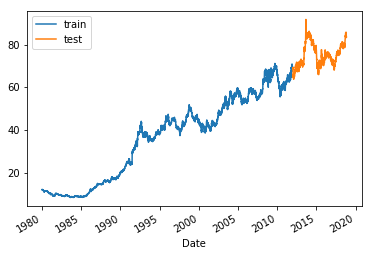

In [33]:
split_date = pd.Timestamp('01-01-2012')

train = df.loc[:split_date]
test = df.loc[split_date:]

ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

In [34]:
sc = MinMaxScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [35]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [36]:
X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [50]:
from keras.layers import LSTM
K.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(7, input_shape=(1, X_train.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
model_lstm.add(Dense(1))

In [51]:
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history_model_lstm = model_lstm.fit(X_tr_t, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])



Epoch 1/100
8321/8321 [==============================] - 26s 3ms/step - loss: 3.0323e-05
Epoch 2/100
8321/8321 [==============================] - 24s 3ms/step - loss: 5.5690e-05
Epoch 3/100
8321/8321 [==============================] - 26s 3ms/step - loss: 6.1120e-05
Epoch 4/100
8321/8321 [==============================] - 25s 3ms/step - loss: 6.3483e-05
Epoch 5/100
8321/8321 [==============================] - 25s 3ms/step - loss: 6.4522e-05
Epoch 6/100
8321/8321 [==============================] - 24s 3ms/step - loss: 6.4378e-05
Epoch 00006: early stopping


In [52]:
y_pred_test_lstm = model_lstm.predict(X_tst_t)
y_train_pred_lstm = model_lstm.predict(X_tr_t)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
r2_train = r2_score(y_train, y_train_pred_lstm)
print("The Adjusted R2 score on the Train set is:\t{:0.3f}\n".format(adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))
r2_test = r2_score(y_test, y_pred_test_lstm)
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))

The R2 score on the Train set is:	0.878
The Adjusted R2 score on the Train set is:	0.878

The R2 score on the Test set is:	0.990
The Adjusted R2 score on the Test set is:	0.990


In [53]:
model_lstm.save('LSTM_model_new.h5')

In [54]:
model_lstm = load_model('LSTM_model_new.h5')

In [55]:
score_lstm= model_lstm.evaluate(X_tst_t, y_test, batch_size=1)

2062/2062 [==============================] - 2s 968us/step


In [56]:
print('LSTM: %f'%score_lstm)

LSTM: 0.000073


In [57]:
y_pred_test_LSTM = model_lstm.predict(X_tst_t)

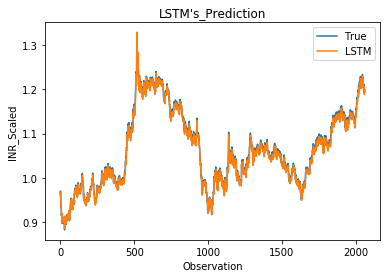

In [58]:
plt.plot(y_test, label='True')
plt.plot(y_pred_test_LSTM, label='LSTM')
plt.title("LSTM's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

In [59]:
col1 = pd.DataFrame(y_test, columns=['True'])

col2 = pd.DataFrame(y_pred_test_LSTM, columns=['LSTM_prediction'])

col3 = pd.DataFrame(history_model_lstm.history['loss'], columns=['Loss_LSTM'])
results = pd.concat([col1, col2, col3], axis=1)
results.to_excel('Prediction_EURO_INR_LSTM.xlsx')